## Apply time series for forecasting on number of students in metro east over time 

In [128]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
import plotly.express as px
from scipy import stats

In [2]:
# load data
enrollment_ts = pd.read_excel('eda/data/enrollment data.xlsx', sheet_name='Clean_PO_Detail')

In [22]:
# create plotly plot that displays multiple time series plots

def plotly_ts(metro, circuit):
    long_enrollment_df = enrollment_ts[['YEAR', 'EDUC DISTRICT', 'TOTAL 1', 'CIRCUIT', 
                                        'PREGRR', 'GRR', 'GR1', 'GR2',
                                        'GR3', 'GR4', 'GR5', 'GR6',
                                        'GR7', 'GR8', 'GR9', 'GR10',
                                        'GR11', 'GR12', 'LSEN']]

    long_enrollment_me_df = long_enrollment_df[long_enrollment_df['EDUC DISTRICT'] == metro]

    # get full dataset into long format
    long_enrollment_me_df = pd.melt(long_enrollment_me_df,
                                    id_vars=['YEAR', 'EDUC DISTRICT', 'CIRCUIT'],
                                    value_vars=['PREGRR', 'GRR', 'GR1', 'GR2',
                                                'GR3', 'GR4', 'GR5', 'GR6',
                                                'GR7', 'GR8', 'GR9', 'GR10',
                                                'GR11', 'GR12', 'LSEN', 'TOTAL 1'])

    # plot line graph (coloured by municipality, line type according to sim)
    fig = px.line(long_enrollment_me_df[long_enrollment_me_df['CIRCUIT'] == circuit], x='YEAR', y='value', color='variable',
    labels={
        'value': 'student enrollment',
        'YEAR': 'Year',
        'variable': 'Grade',
    },
    title = 'Enrollment Time Series')
    fig.show()

plotly_ts('METRO EAST', 8)

In [28]:
def subtract_from_previous(arr):
    if len(arr) == 0:
        return []

    return [arr[i] - arr[i - 1] for i in range(1, len(arr))]

0.016768998403396115

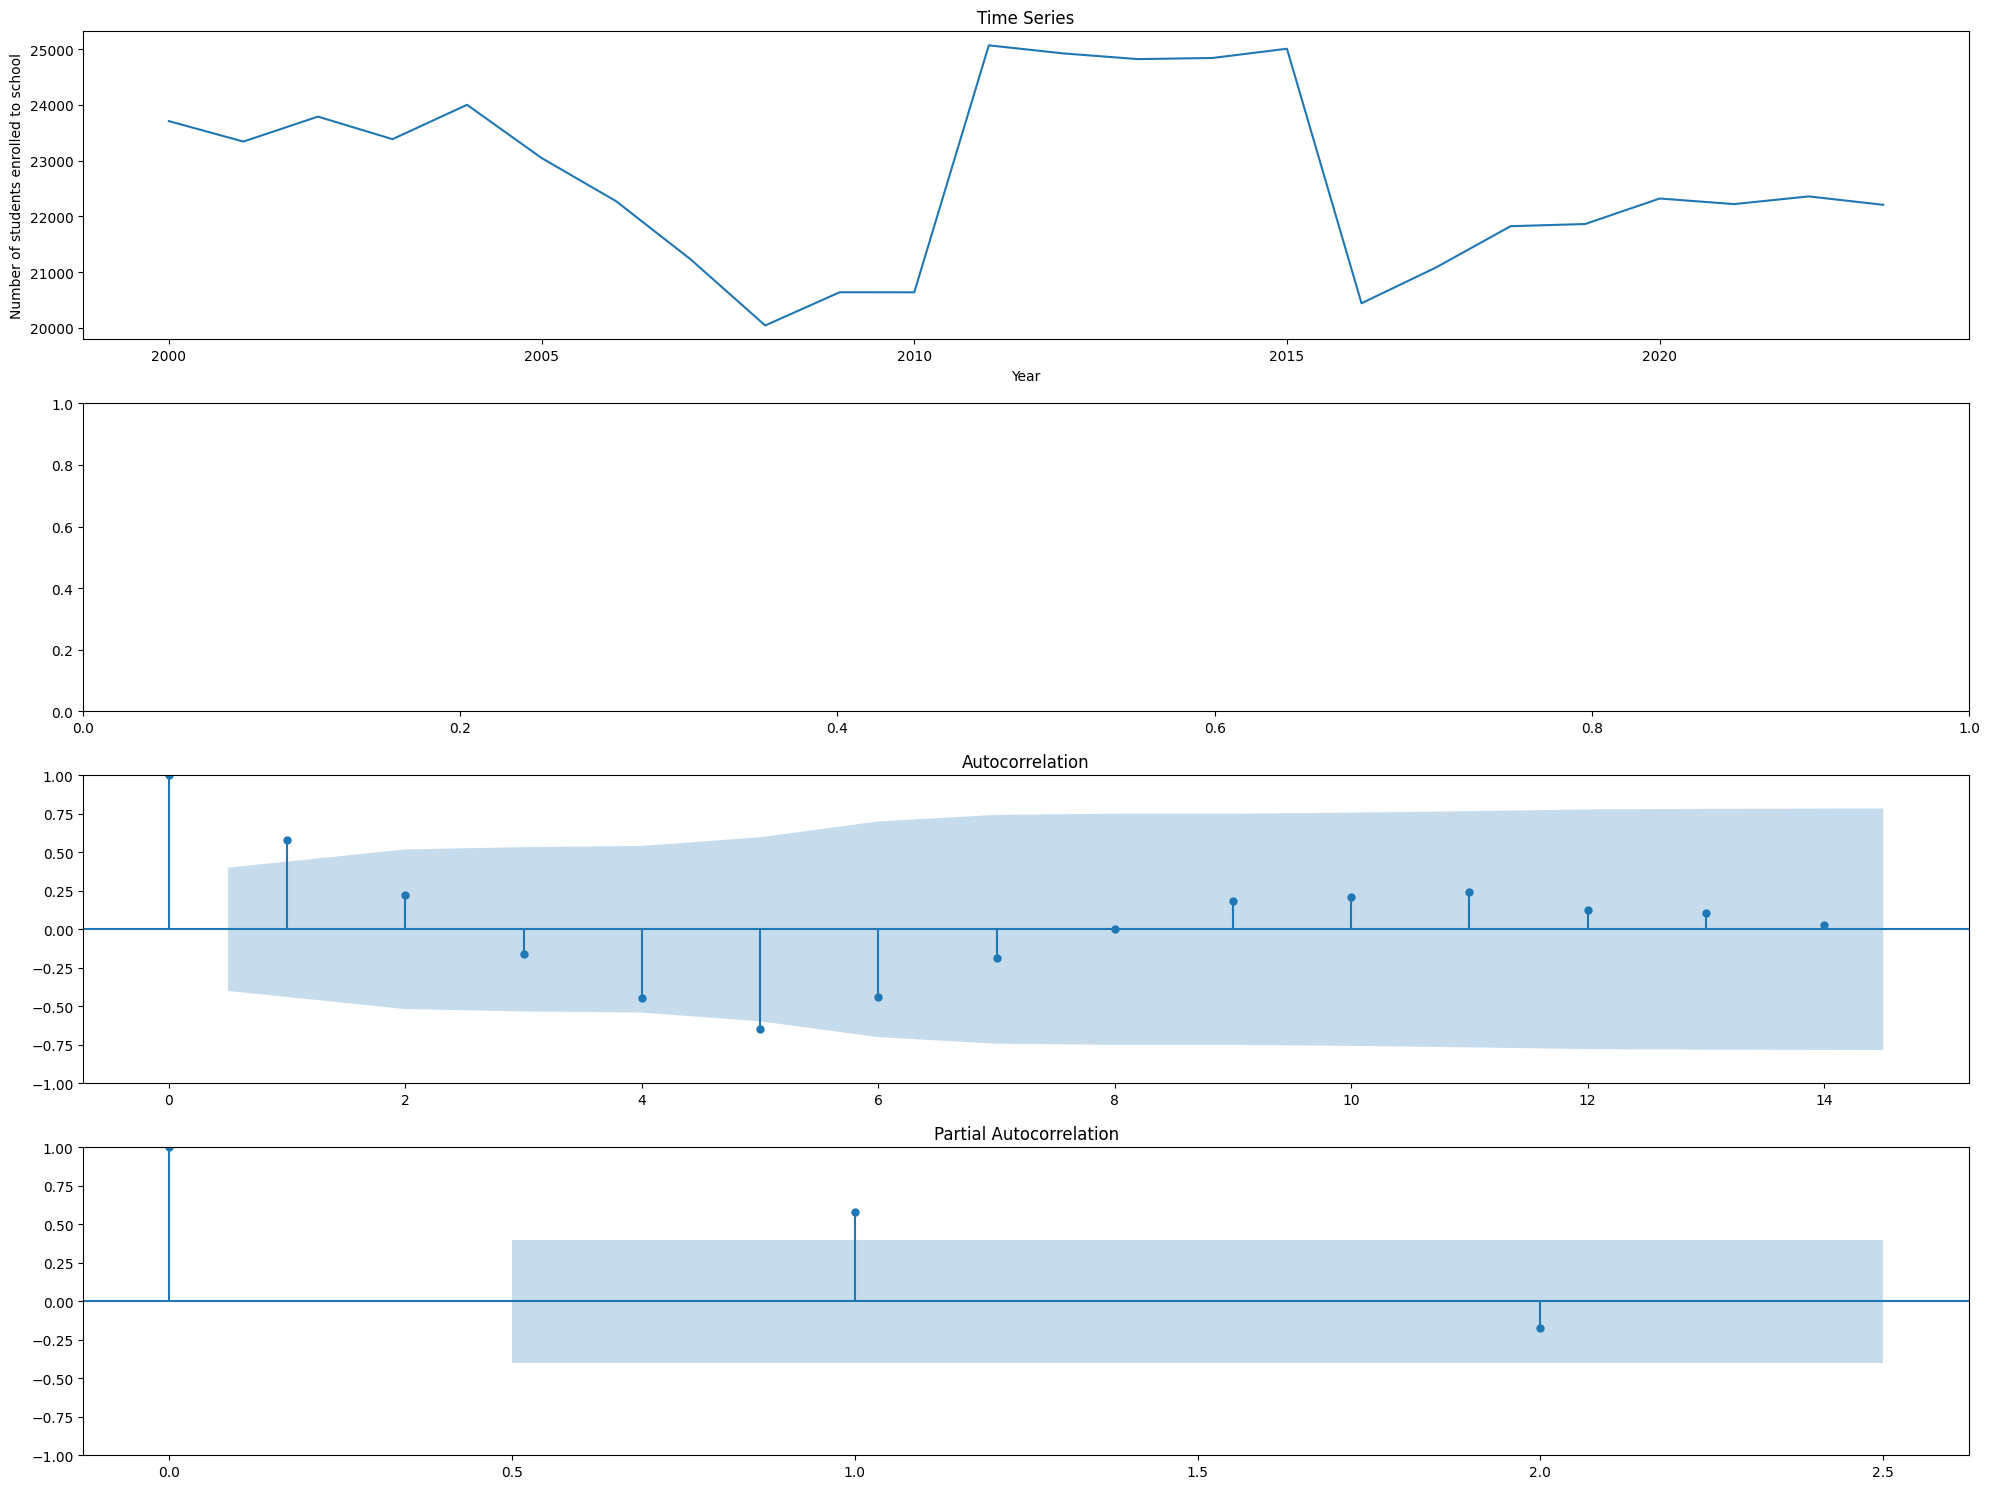

In [233]:
# This function plots time series of student enrollment for a given metro, circuit and grade
# If the time series is not stationary it is converted so that it is stationary and the stationary plot will be plotted
# the pacf and acf plots are also plotted
fig, axes = plt.subplots(4, 1, figsize=(20,15))
def plot_learner_ts(metro, circuit, count_var):
    
    # filter dataset
    enrollment_subset = enrollment_ts[(enrollment_ts['EDUC DISTRICT'] == str(metro)) & (enrollment_ts['CIRCUIT'] == int(circuit))][[str(count_var), 'YEAR']]

    # plot the stationary time series if time series is not stationary
    adf_val = adfuller(enrollment_subset[str(count_var)])
    
    # if p val > 0.05 then time series is not stationary. If p value < 0.05 then it is stationary
    # if time series is stationary then convert to stationary plot
    if adf_val[1] > 0.05:
        # plot number of students over time
        axes[0].plot(enrollment_subset['YEAR'], (enrollment_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # convert time series to stationary time series
        transformed_ts = subtract_from_previous(np.array(enrollment_subset[str(count_var)]))
        transformed_adf = adfuller(transformed_ts)

        axes[1].plot(enrollment_subset['YEAR'][1:], transformed_ts) # time series for stationary plot
        axes[1].set_title('Stationary Time Series')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(np.array(transformed_ts), ax=axes[2]) # acf for stationary plot

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(transformed_ts, lags=5, ax=axes[3]) # pacf for stationary plot
    
    # if the time series is already stationary then plot the time series, acf and pacf plots as is
    else:
        # plot number of students over time
        axes[0].plot(enrollment_subset['YEAR'], (enrollment_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(enrollment_subset[str(count_var)], ax=axes[2])

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(enrollment_subset[str(count_var)], lags=2, ax=axes[3])

    # plot all graphs on same grid
    plt.tight_layout()

    # return transformed adf only if the transformation needed to happen
    if adf_val[1] > 0.05:
        return [adf_val[1], transformed_adf[1]]
    else:
        return adf_val[1]

plot_learner_ts('METRO EAST', '3', 'TOTAL 1')

In [ ]:
# filter the enrollment dataframe
def filter_df(df, metro, circuit, variable):
    return df[(df['EDUC DISTRICT'] == str(metro)) & (df['CIRCUIT'] == circuit)][[str(variable), 'YEAR']]

enrollment_subset = filter_df(enrollment_ts, 'METRO EAST', 3, 'TOTAL 1')
enrollment_subset


In [235]:
# create function that applies arma model to time series of subset
def enrollment_arma(df, ar, ma, dif):
    
    # format data and index by date variable
    start_year = str(enrollment_subset[0:1]['YEAR'].values[0])
    end_year = str(enrollment_subset[-1:]['YEAR'].values[0])

    # index thee values using a date value
    df.index = pd.Index(sm.tsa.datetools.dates_from_range(start_year, end_year))
    df.index.freq = enrollment_subset.index.inferred_freq
    del df["YEAR"]

    # split into train and test sets (not sure this is necessary)
    train = df[:20]
    test = df[20:23]

    # apply arima
    arma_mod = ARIMA(train, order=(ar, dif, ma)).fit()
    
    return arma_mod


arma_mod = enrollment_arma(enrollment_subset, 1, 1, 0)

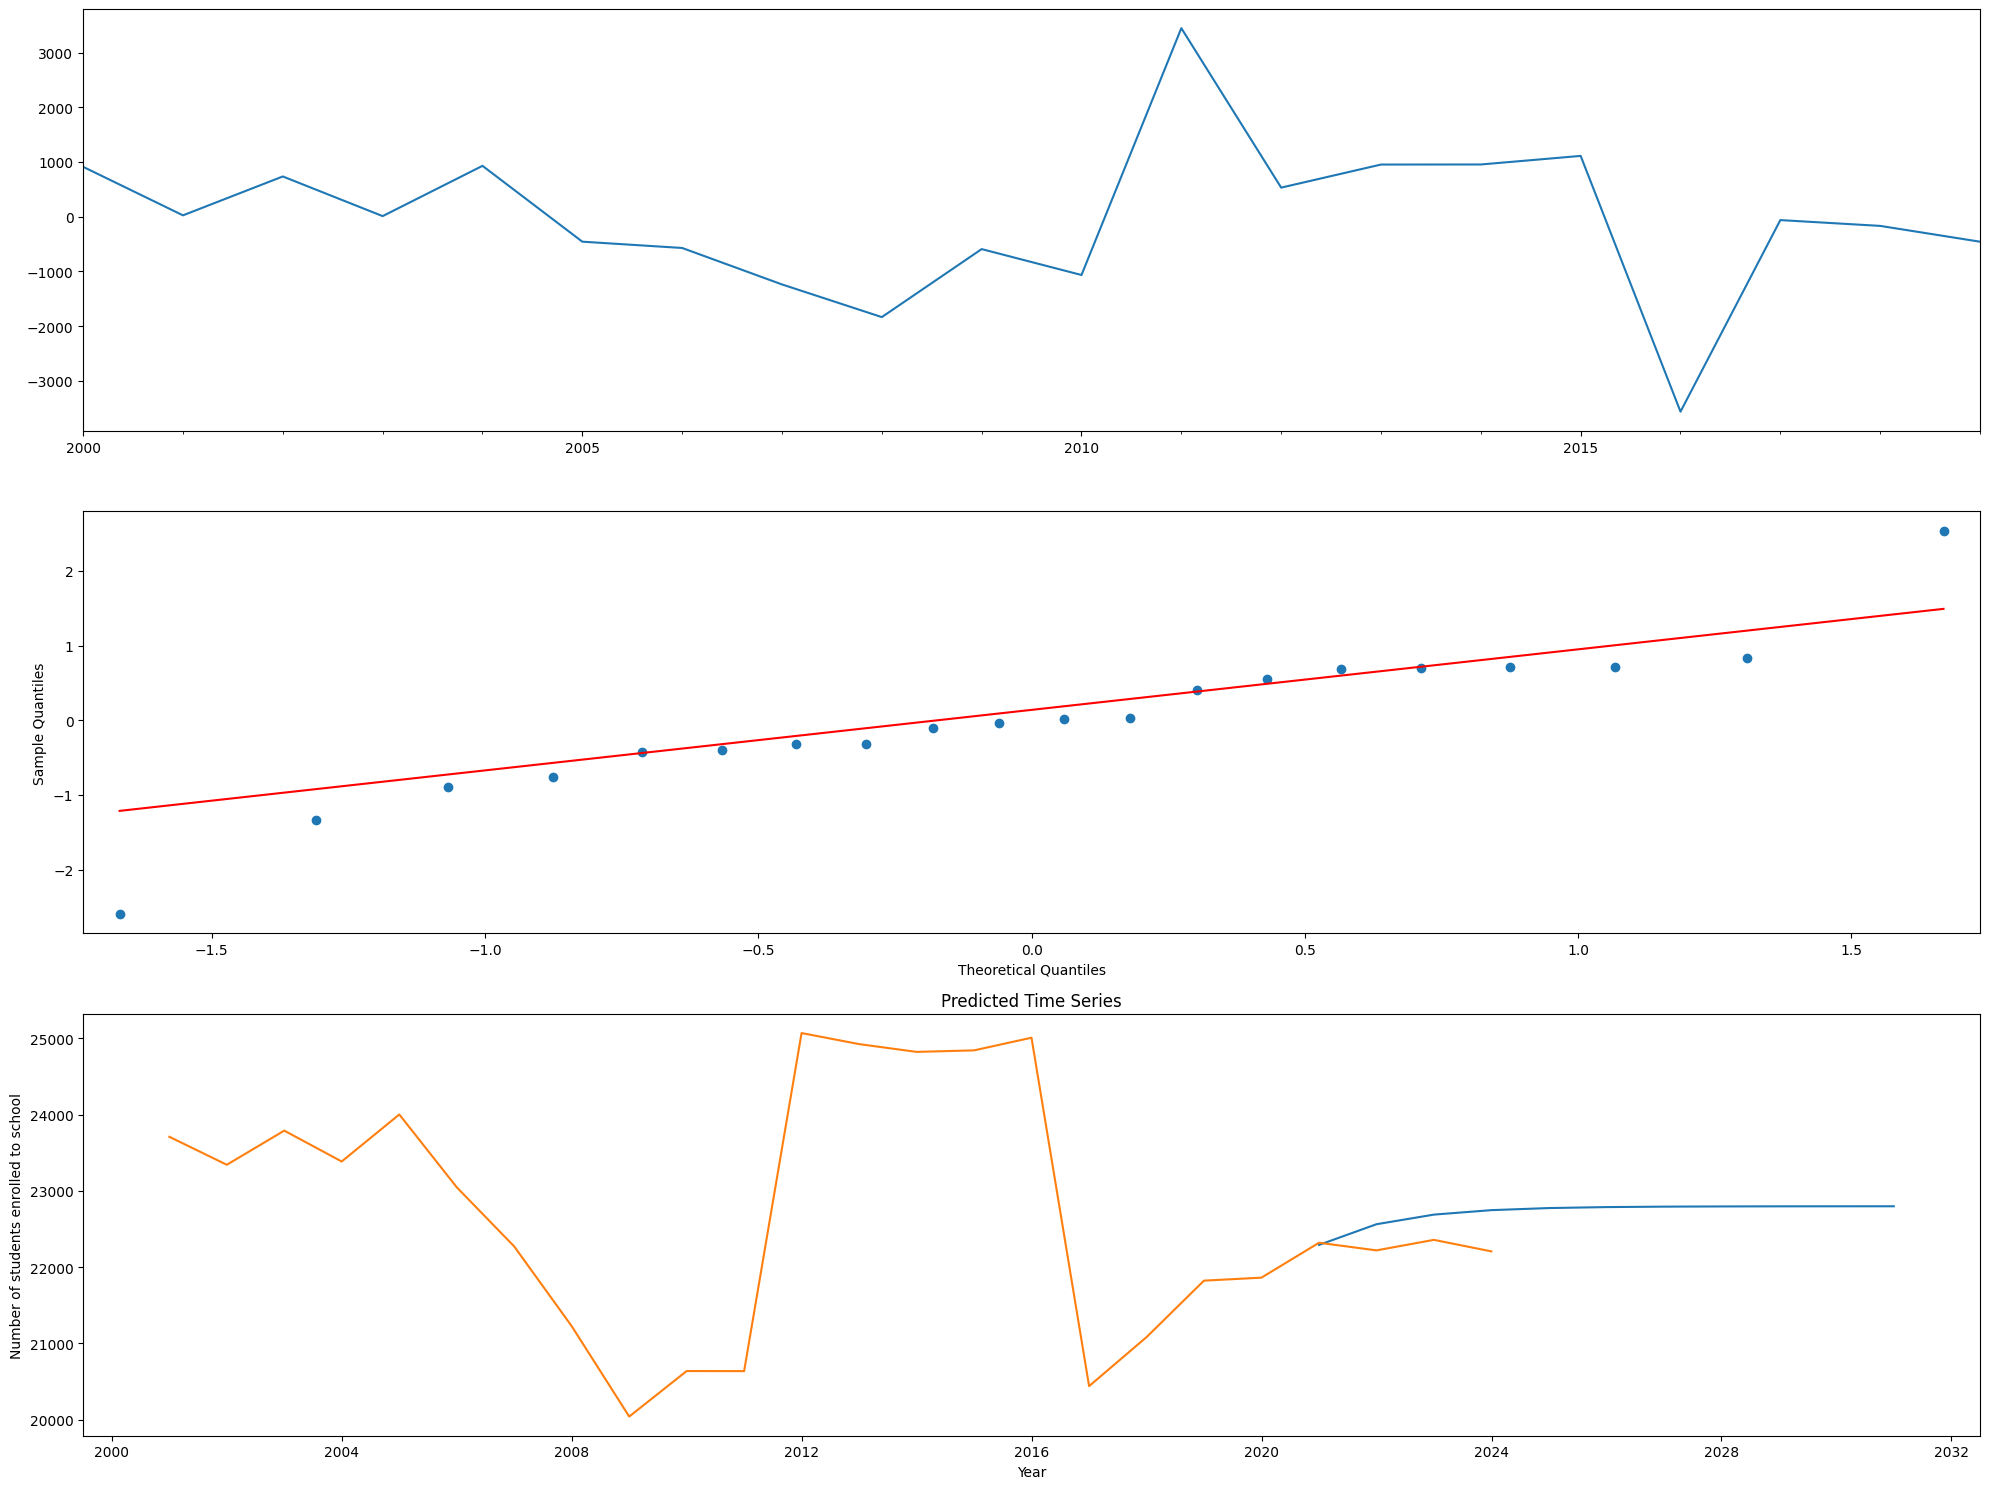

In [236]:
fig, axes = plt.subplots(3, 1, figsize=(20,15))

# function to plot residual tests for arma model an the predicted outcomes
def plot_ts_predictions(df, arma_model):

    # residual plot (should have mean of 0)
    ax = arma_model.resid.plot(ax=axes[0])

    # normal test for residual plot (residuals should be normally distributed)
    resid = arma_model.resid
    stats.normaltest(resid)
    fig = qqplot(resid, line="q", ax=axes[1], fit=True)

    # make predictions
    enrol_preds = pd.DataFrame(arma_model.predict("2020", "2030", dynamic=True))
    enrol_preds.rename(columns={'predicted_mean':'TOTAL 1'}, inplace=True)

    # plot enrollment predictions against
    axes[2].plot(enrol_preds)
    axes[2].plot(df)
    axes[2].set_title('Predicted Time Series')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Number of students enrolled to school')

    # plot all graphs on same grid
    plt.tight_layout()    

plot_ts_predictions(enrollment_subset, arma_mod)